<a href="https://colab.research.google.com/github/bforsbe/SK2534/blob/main/omegafold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**OmegaFold**
for more details see: [Github](https://github.com/HeliXonProtein/OmegaFold), [Preprint](https://www.biorxiv.org/content/10.1101/2022.07.21.500999v1)

#### **Tips and Instructions**
- click the little ▶ play icon to the left of each cell below.
- use "/" to specify chainbreaks, (eg. sequence="AAA/AAA")
- for homo-oligomeric predictions, set copies > 1


In [1]:
#@markdown ##Install
import os,sys,re
from IPython.utils import io
if "SETUP_DONE" not in dir():
  import torch
  device = "cuda" if torch.cuda.is_available() else "cpu"
  with io.capture_output() as captured:
    if not os.path.isdir("OmegaFold"):
      %shell git clone --branch beta --quiet https://github.com/sokrypton/OmegaFold.git
      # %shell cd OmegaFold; pip -q install -r requirements.txt
      %shell pip -q install py3Dmol biopython==1.81
      %shell apt-get install aria2 -qq > /dev/null
      %shell aria2c -q -x 16 https://helixon.s3.amazonaws.com/release1.pt
      %shell mkdir -p ~/.cache/omegafold_ckpt
      %shell mv release1.pt ~/.cache/omegafold_ckpt/model.pt
  SETUP_DONE = True

In [9]:
#@markdown ##Run **OmegaFold**
from string import ascii_uppercase, ascii_lowercase
import hashlib
import torch
from IPython.utils import io

# Define device here to ensure it's available
device = "cuda" if torch.cuda.is_available() else "cpu"

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "test" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "MKVIFLKKGEIKNVADGYANNFLFKQGLAIEA" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)

copies = 1 #@param {type:"integer"}
sequence = ":".join([sequence] * copies)
#@markdown **Advanced Options**
num_cycle = 2 #@param ["1", "2", "4", "8", "16", "32"] {type:"raw"}
offset_rope = False #@param {type:"boolean"}

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]

subbatch_size = 1000 #@param
def get_subbatch_size(L):
  if L <  500: return 500
  if L < 1000: return 200
  return 150
if subbatch_size < 0:
    subbatch_size = get_subbatch_size(sum(lengths))

u_seqs = list(set(seqs))

if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

with open(f"{ID}.fasta","w") as out:
  out.write(f">{ID}\n{sequence}\n")

# Construct the shell command, handling the boolean offset_rope
shell_command = f"python OmegaFold/main.py --device={device} --subbatch_size={subbatch_size} --num_cycle={num_cycle} {ID}.fasta ."
if offset_rope:
    shell_command = f"python OmegaFold/main.py --offset_rope --device={device} --subbatch_size={subbatch_size} --num_cycle={num_cycle} {ID}.fasta ."

%shell {shell_command}

def renum_pdb_str(pdb_str, Ls=None, renum=True, offset=1):
  if Ls is not None:
    L_init = 0
    new_chain = {}
    for L,c in zip(Ls, alphabet_list):
      new_chain.update({i:c for i in range(L_init,L_init+L)})
      L_init += L

  n,num,pdb_out = 0,offset,[]
  resnum_ = None
  chain_ = None
  new_chain_ = new_chain[0]
  for line in pdb_str.split("\n"):
    if line[:4] == "ATOM":
      chain = line[21:22]
      resnum = int(line[22:22+5])
      if resnum_ is None: resnum_ = resnum
      if chain_ is None: chain_ = chain
      if resnum != resnum_ or chain != chain_:
        num += (resnum - resnum_)
        n += 1
        resnum_,chain_ = resnum,chain
      if Ls is not None:
        if new_chain[n] != new_chain_:
          num = offset
          new_chain_ = new_chain[n]
      N = num if renum else resnum
      if Ls is None: pdb_out.append("%s%4i%s" % (line[:22],N,line[26:]))
      else: pdb_out.append("%s%s%4i%s" % (line[:21],new_chain[n],N,line[26:]))
  return "\n".join(pdb_out)

pdb_str = renum_pdb_str(open(f"{ID}.pdb",'r').read(), Ls=lengths)
o_pdb_file=f"{ID}.pdb"
with open(o_pdb_file,"w") as out:
  out.write(pdb_str)

/usr/local/lib/python3.12/dist-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(
/content/OmegaFold/omegafold/utils/protein_utils/residue_constants.py:483: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /pytorch/aten/src/ATen/native/Cross.cpp:63.)
  eznorm = torch.cross(ex_normalized, ey_normalized)
INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading test_a2395.fasta
INFO:root:Predicting 1th chain in test_a2395.fasta
INFO:root:32 residues in this chain.
INFO:root:Finished prediction in 1.61 seconds.
INFO:root:Saving prediction to ./test_a2395.pdb
INFO:root:Saved


In [3]:
#@markdown ##Display
import py3Dmol


pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    HP = ["ALA","GLY","VAL","ILE","LEU","PHE","MET","PRO","TRP","CYS","TYR"]
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color, show_sidechains=show_sidechains, show_mainchains=show_mainchains,
         Ls=lengths).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
#@title Mutate DNA and inspect translation
from IPython.display import display, HTML
from textwrap import wrap
import Bio
from Bio.Seq import Seq

# === Inputs ===
original_seq = "ATG AAA GTG ATT TTT CTG AAA AAA GGC GAA ATT AAA AAC GTG GCG GAT GGC TAT GCG AAC AAC TTT CTG TTT AAA CAG GGC CTG GCG ATT GAA GCG" #@param {type:"string"}
mutated_seq  = "ATG AAA GTG ATT TTT CTG AAA ATA GGC GAA ATT AAA AAC GTG GCG GAT GGC TAT GCG AAC AAC TTT CTG TTT AAA CAG GGC CTG GCG ATT GAA GCG" #@param {type:"string"}

# Clean input
original_seq = original_seq.replace(" ", "").upper()
mutated_seq  = mutated_seq.replace(" ", "").upper()

# === Checks ===
if len(original_seq) != len(mutated_seq):
    raise ValueError(f"Sequences must have the same length (got {len(original_seq)} vs {len(mutated_seq)}).")
if len(original_seq) % 3 != 0:
    raise ValueError(f"Sequence length must be a multiple of 3 (got {len(original_seq)}).")

# === Genetic code (DNA codons) ===
codon_table = {
    "TTT":"F","TTC":"F","TTA":"L","TTG":"L",
    "CTT":"L","CTC":"L","CTA":"L","CTG":"L",
    "ATT":"I","ATC":"I","ATA":"I","ATG":"M",
    "GTT":"V","GTC":"V","GTA":"V","GTG":"V",
    "TCT":"S","TCC":"S","TCA":"S","TCG":"S",
    "CCT":"P","CCC":"P","CCA":"P","CCG":"P",
    "ACT":"T","ACC":"T","ACA":"T","ACG":"T",
    "GCT":"A","GCC":"A","GCA":"A","GCG":"A",
    "TAT":"Y","TAC":"Y","TAA":"*","TAG":"*",
    "CAT":"H","CAC":"H","CAA":"Q","CAG":"Q",
    "AAT":"N","AAC":"N","AAA":"K","AAG":"K",
    "GAT":"D","GAC":"D","GAA":"E","GAG":"E",
    "TGT":"C","TGC":"C","TGA":"*","TGG":"W",
    "CGT":"R","CGC":"R","CGA":"R","CGG":"R",
    "AGT":"S","AGC":"S","AGA":"R","AGG":"R",
    "GGT":"G","GGC":"G","GGA":"G","GGG":"G"
}

def translate_dna(seq):
    codons = wrap(seq, 3)
    aa = [codon_table.get(c,"?") for c in codons]
    return codons, aa

from IPython.display import display, HTML

def compare_sequences(seq1, seq2, space_every=10, spacer=" ", no_number=False):
    """
    Display two sequences in monospace, highlight differences in bold red,
    insert spaces every n characters, and add numbering above each block.
    """
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must be the same length")

    def highlight_block(s1, s2):
        """Highlight differences in one block of equal length"""
        out1, out2 = [], []
        for a, b in zip(s1, s2):
            out1.append(a)
            if a == b:
                out2.append(b)
            else:
                out2.append(f"<span style='color:red;font-weight:bold'>{b}</span>")
        return "".join(out1), "".join(out2)

    # Split into blocks of size space_every
    blocks1 = [seq1[i:i+space_every] for i in range(0, len(seq1), space_every)]
    blocks2 = [seq2[i:i+space_every] for i in range(0, len(seq2), space_every)]

    seq1_blocks, seq2_blocks, num_blocks = [], [], []
    pos = 0
    for b1, b2 in zip(blocks1, blocks2):
        o1, o2 = highlight_block(b1, b2)
        seq1_blocks.append(o1)
        seq2_blocks.append(o2)
        pos += len(b1)
        num_blocks.append(str(pos).rjust(len(b1)))


    number_line = spacer.join(num_blocks)
    seq1_line   = spacer.join(seq1_blocks)
    seq2_line   = spacer.join(seq2_blocks)

    html = []
    if no_number:
        html = seq1_line + "<br>" + seq2_line
    else:
        html = number_line + "<br>" + seq1_line + "<br>" + seq2_line
    display(HTML(f"<pre style='font-family:monospace'>{html}</pre>"))

def dna_identity(seq1: str, seq2: str) -> float:
    """Return % identity at DNA level"""
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must have the same length")
    matches = sum(a == b for a, b in zip(seq1.upper(), seq2.upper()))
    return 100 * matches / len(seq1)

def protein_identity(seq1: str, seq2: str) -> float:
    """Translate DNA → protein and return % identity"""
    if len(seq1) % 3 != 0 or len(seq2) % 3 != 0:
        raise ValueError("DNA sequences must be divisible by 3")
    prot1 = str(Seq(seq1).translate(to_stop=False))
    prot2 = str(Seq(seq2).translate(to_stop=False))
    if len(prot1) != len(prot2):
        raise ValueError("Translated proteins have different lengths")
    matches = sum(a == b for a, b in zip(prot1, prot2))
    return 100 * matches / len(prot1)

def mutation_score(seq1: str, seq2: str) -> float:
    """Return mutation score"""
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must have the same length")

    protein_id = protein_identity(seq1, seq2)
    dna_id = dna_identity(seq1, seq2)

    return ((100.-protein_id)+(100.-dna_id))/2

# === Translation ===
codons_o, aa_o = translate_dna(original_seq)
codons_m, aa_m = translate_dna(mutated_seq)

# === HTML display ===

compare_sequences(original_seq,mutated_seq,space_every=3)
compare_sequences(aa_o,aa_m,space_every=1, no_number=True, spacer="   ")

#display(HTML(f"<pre style='font-family:monospace'>{"   ".join(aa_o)}</pre>"))
#compare_sequences("".join(codons_o),"".join(codons_m),space_every=30)

print("\n\nMutaded sequence without spaces:")
display(HTML(f"<pre style='font-family:monospace'>{"".join(aa_m)}</pre>"))

dna_id = dna_identity(original_seq, mutated_seq)
#print(f"\nDNA % identity: {dna_id:.1f}%")
protein_id = protein_identity(original_seq, mutated_seq)
#print(f"Protein % identity: {protein_id:.1f}%")
print("\n")
mut_score = mutation_score(original_seq,mutated_seq)
print(f"Mutation score is {mut_score:.2f}")




Mutaded sequence without spaces:




Mutation score is 2.08


In [5]:
#@title Calculate RMSD-based final score
import os, re, requests
import torch
from jax.tree_util import tree_map
from Bio.Seq import Seq
from Bio.PDB import PDBParser, Superimposer, PDBIO
import numpy as np
import tempfile

# --- Superpose prediction onto reference ---
def align_pred_to_ref(pred_pdb_str, ref_pdb_file, out_file="pred_aligned.pdb"):
    parser = PDBParser(QUIET=True)

    # Save predicted PDB string to temp file
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pdb") as tmp_pred:
        tmp_pred.write(pred_pdb_str.encode())
        pred_file = tmp_pred.name

    pred = parser.get_structure("pred", pred_file)
    ref  = parser.get_structure("ref", ref_pdb_file)

    # Use CA atoms for alignment
    pred_atoms = [a for a in pred.get_atoms() if a.get_id() == "CA"]
    ref_atoms  = [a for a in ref.get_atoms()  if a.get_id() == "CA"]

    n = min(len(pred_atoms), len(ref_atoms))
    si = Superimposer()
    si.set_atoms(ref_atoms[:n], pred_atoms[:n])  # align prediction to reference
    si.apply(pred.get_atoms())                   # apply transform to prediction

    # Write aligned prediction
    io = PDBIO()
    io.set_structure(pred)
    io.save(out_file)

    return out_file, si.rms

def rmsd_to_similarity(rmsd, sigma=2.0):
    """
    Convert RMSD (Å) to a similarity score in [0,1].
    Smaller RMSD -> score close to 1, larger RMSD -> score close to 0.

    Parameters
    ----------
    rmsd : float or np.array
        Root-mean-square deviation in angstroms.
    sigma : float
        Scaling factor controlling decay. Typical RMSDs of 1-2 Å → high similarity.

    Returns
    -------
    similarity : float or np.array
        Score in [0,1].
    """
    return np.exp(-rmsd / sigma)

# --- Download reference PDB ---
ref_file="reference.pdb"
if not os.path.isfile(ref_file):
  !wget -q -O reference.pdb https://raw.githubusercontent.com/bforsbe/SK2534/main/reference_omega.pdb

aligned_file, rmsd_val = align_pred_to_ref(pdb_str, ref_file)

#for rmsd in [0.5, 1.0, 2.0, 5.0]:
#    print(rmsd, rmsd_to_similarity(rmsd))
pred_sim_score = rmsd_to_similarity(rmsd_val)
mut_score=mutation_score(original_seq,mutated_seq)

# --- Compare ---
print(f"Input file is {o_pdb_file}")
#print(f"Protein sequence: {protein_seq}")
print(f"mutation score: \t{mut_score:.2f})")
print(f"RMSD vs reference: \t{rmsd_val:.3f} Å (score: {pred_sim_score:.2f})")
print("\n\n")
print(f"Total score: \t{mut_score*pred_sim_score:.3f}")


Input file is test_a2395.pdb
mutation score: 	2.08)
RMSD vs reference: 	0.000 Å (score: 1.00)



Total score: 	2.083


In [6]:
#@title Display predicted (superposed) + reference {run: "auto"}
import py3Dmol
from Bio.PDB import PDBParser, Superimposer, PDBIO
import tempfile, os

# --- Visualize both ---
def show_pred_and_ref_aligned(pred_pdb_str, ref_pdb_file,
                              color="pLDDT", show_sidechains=False, show_mainchains=False,
                              chains=None, vmin=50, vmax=90, size=(800,480), Ls=None, hide_pred=False):

    aligned_file, rmsd = align_pred_to_ref(pred_pdb_str, ref_pdb_file)

    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',
                        width=size[0], height=size[1])

    # Reference (fixed, green)
    with open(ref_pdb_file) as f:
        ref_pdb_str = f.read()
    view.addModel(ref_pdb_str,'pdb')
    view.setStyle({'model':0},{'cartoon':{'color':'green','opacity':0.7}})

    # Prediction (aligned, colored)
    with open(aligned_file) as f:
        pred_aligned_str = f.read()
    if not hide_pred:
        view.addModel(pred_aligned_str,'pdb')
    if color == "pLDDT":
        view.setStyle({'model':1,'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
    elif color == "rainbow":
        view.setStyle({'model':1,'cartoon': {'color':'spectrum'}})
    elif color == "chain":
        from string import ascii_uppercase
        alphabet_list = list(ascii_uppercase)
        for n,chain,c in zip(range(chains),alphabet_list,pymol_color_list):
            view.setStyle({'model':1,'chain':chain},{'cartoon': {'color':c}})

    if show_sidechains:
        view.addStyle({'model':1,'stick':{}})

    view.zoomTo()
    print(f"Structural alignment RMSD: {rmsd:.3f} Å")
    return view


# --- Params ---
color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = True #@param {type:"boolean"}
show_mainchains = True #@param {type:"boolean"}
hide_predicted = False #@param {type:"boolean"}

# --- Run ---

show_pred_and_ref_aligned(pdb_str, "reference.pdb",
                          color=color,
                          show_sidechains=show_sidechains,
                          show_mainchains=show_mainchains,
                          Ls=lengths,
                          hide_pred=hide_predicted).show()

Structural alignment RMSD: 0.000 Å


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [7]:
#@title Define mutation limits

conservative_substitutions = {
    'A': ['G', 'S', 'T'], # Alanine (small, nonpolar)
    'R': ['K', 'H'],     # Arginine (basic, positive)
    'N': ['Q', 'S', 'T'], # Asparagine (polar, uncharged)
    'D': ['E'],          # Aspartic Acid (acidic, negative)
    'C': ['S'],          # Cysteine (sulfur-containing)
    'Q': ['N', 'H', 'K', 'R', 'E', 'D'], # Glutamine (polar, uncharged) - larger group due to flexibility
    'E': ['D', 'Q', 'N', 'K', 'R', 'H'], # Glutamic Acid (acidic, negative) - larger group due to flexibility
    'G': ['A', 'S'],     # Glycine (small, nonpolar)
    'H': ['R', 'K', 'N', 'Q'], # Histidine (basic, positive, aromatic)
    'I': ['L', 'V', 'M'], # Isoleucine (hydrophobic)
    'L': ['I', 'V', 'M'], # Leucine (hydrophobic)
    'K': ['R', 'H', 'Q', 'N'], # Lysine (basic, positive)
    'M': ['L', 'I', 'V'], # Methionine (hydrophobic, sulfur-containing)
    'F': ['Y', 'W'],     # Phenylalanine (aromatic, hydrophobic)
    'P': [],             # Proline (cyclic, often disrupts structure - few conservative substitutions)
    'S': ['T', 'N', 'Q', 'A', 'G', 'C'], # Serine (polar, uncharged, hydroxyl)
    'T': ['S', 'N', 'Q', 'A', 'G'], # Threonine (polar, uncharged, hydroxyl)
    'W': ['Y', 'F'],     # Tryptophan (aromatic, hydrophobic, large)
    'Y': ['F', 'W'],     # Tyrosine (aromatic, hydrophobic, hydroxyl)
    'V': ['I', 'L', 'M']  # Valine (hydrophobic)
}

def generate_conservative_mutations(dna_sequence, codon_position):
    """
    Generates a list of mutated DNA sequences with conservative amino acid
    substitutions at a given codon position.

    Args:
        dna_sequence: The original DNA sequence string.
        codon_position: The 0-indexed position of the codon to mutate.

    Returns:
        A list of mutated DNA sequences.
    """
    start_index = codon_position * 3
    end_index = start_index + 3
    original_codon = dna_sequence[start_index:end_index]

    if original_codon not in codon_table:
        print(f"Warning: Original codon '{original_codon}' not found in codon table.")
        return []

    original_amino_acid = codon_table[original_codon]

    if original_amino_acid not in conservative_substitutions:
        # Handle stop codons or amino acids with no defined conservative substitutions
        return []

    conservative_aas = conservative_substitutions[original_amino_acid]

    mutated_sequences = []
    for sub_aa in conservative_aas:
        for codon, aa in codon_table.items():
            if aa == sub_aa:
                mutated_seq = list(dna_sequence)
                mutated_seq[start_index:end_index] = list(codon)
                mutated_sequences.append("".join(mutated_seq))

    return mutated_sequences

# Example usage (assuming original_seq is defined from previous cells)
# For testing, let's use the first codon (position 0)
# mutated_dna_list = generate_conservative_mutations(original_seq, 0)
# print(f"Original DNA: {original_seq}")
# print(f"Mutated DNA sequences (conservative substitutions at position 0):")
# for mut_seq in mutated_dna_list:
#     print(mut_seq)


In [17]:
# @title Iterative mutation evolution

import numpy as np
import numpy.random as random
import os, re, requests # Import necessary modules for OmegaFold and file handling
from string import ascii_uppercase, ascii_lowercase # Import for chain naming
import hashlib # Import for hashing sequence
import pickle # Import for saving/loading

num_iterations = 200 # @param {type:"integer"}
save_history = True # @param {type:"boolean"}
history_filename = "mutation_history.pkl" # @param {type:"string"}
load_history = True # @param {type:"boolean"}

# Function to get hash for jobname
def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

# Load history if requested
if load_history and os.path.exists(history_filename):
    print(f"Loading history from {history_filename}")
    with open(history_filename, 'rb') as f:
        history = pickle.load(f)
    best_dna_sequence = history['best_dna_sequence']
    best_protein_sequence = history['best_protein_sequence']
    best_total_score = history['best_total_score']
    accepted_mutation_scores = history['accepted_mutation_scores']
    accepted_sim_scores = history['accepted_sim_scores']
    accepted_total_scores = history['accepted_total_scores']
    accepted_iterations = history['accepted_iterations']
    all_mutation_scores = history['all_mutation_scores']
    all_sim_scores = history['all_sim_scores']
    all_total_scores = history['all_total_scores']
    all_iterations = history['all_iterations']
    all_tried_protein_sequences = history['all_tried_protein_sequences']
    completed_iters = history['completed_iters']
else:
    best_dna_sequence = original_seq
    best_protein_sequence = str(Bio.Seq.Seq(best_dna_sequence).translate(to_stop=False))
    best_total_score = -1

    accepted_mutation_scores = []
    accepted_sim_scores = []
    accepted_total_scores = []
    accepted_iterations = []
    all_mutation_scores = []
    all_sim_scores = []
    all_total_scores = []
    all_iterations = []

    all_tried_protein_sequences = []
    all_tried_protein_sequences.append(best_protein_sequence)

    completed_iters = 0

num_codons = len(original_seq) // 3


while completed_iters < num_iterations:
    # Choose a random codon position to mutate
    random_codon_pos = random.randint(0, num_codons - 1)

    # Generate conservative mutations for this position
    # This part seems a bit off, it should generate a list and then pick one
    mutated_dna_list_single = generate_conservative_mutations(best_dna_sequence, random_codon_pos)


    if not mutated_dna_list_single:
        continue # Skip to the next iteration if no mutations are possible

    # Select the first generated mutation (or choose randomly)
    single_mutated_dna_seq = random.choice(mutated_dna_list_single) # Use random.choice to pick one mutation
    single_mutated_protein_seq = str(Bio.Seq.Seq(single_mutated_dna_seq).translate(to_stop=False))

    # Check if protein sequence has been tried before
    if single_mutated_protein_seq in all_tried_protein_sequences:
        continue

    all_tried_protein_sequences.append(single_mutated_protein_seq)

    # Predict structure using OmegaFold
    # Adapt the OmegaFold execution code from cell CFCwEAa2oZEN
    try:
        # Generate a unique jobname based on iteration and a hash of the sequence
        jobname = f"iter_{completed_iters}_{get_hash(single_mutated_protein_seq)[:5]}"
        ID = jobname
        seqs = single_mutated_protein_seq.split(":")
        lengths = [len(s) for s in seqs]

        # Write fasta file
        with open(f"{ID}.fasta","w") as out:
            out.write(f">{ID}\n{single_mutated_protein_seq}\n")

        # Run OmegaFold command
        # Use appropriate parameters, likely inherited from the successful OmegaFold cell
        subbatch_size = 1000 # Assuming single chain, length < 500 from previous cell
        num_cycle = 2 # Assuming from previous cell
        offset_rope = False # Assuming from previous cell
        device = "cuda" if torch.cuda.is_available() else "cpu" # Get device from setup cell

        # Execute OmegaFold prediction
        # Capture output to keep the notebook clean
        with io.capture_output() as captured:
            %shell python OmegaFold/main.py --offset_rope={offset_rope} --device={device} --subbatch_size={subbatch_size} --num_cycle={num_cycle} {ID}.fasta .

        # Define the predicted PDB file name
        single_mutated_pdb_file = f"{ID}.pdb"

        # Read the predicted PDB file
        with open(single_mutated_pdb_file, 'r') as f:
            single_mutated_pdb_str = f.read()

        # Renumber PDB if necessary (using the function from CFCwEAa2oZEN)
        single_mutated_pdb_str = renum_pdb_str(single_mutated_pdb_str, Ls=lengths)
        # Save the renumbered PDB string to a file for alignment
        with open(single_mutated_pdb_file, "w") as out:
             out.write(single_mutated_pdb_str)


        # Align to reference and calculate RMSD (using the function from c51BDdsXe68l)
        aligned_file_single, single_mutated_rmsd_val = align_pred_to_ref(single_mutated_pdb_str, "reference.pdb", out_file=f"{ID}_aligned.pdb")


        # Convert RMSD to similarity score (using the function from c51BDdsXe68l)
        single_mutated_pred_sim_score = rmsd_to_similarity(single_mutated_rmsd_val)

        # Calculate mutation score (using the function from z3HeD2V8epVW)
        single_current_mutation_score = mutation_score(original_seq, single_mutated_dna_seq)

        # Calculate total score
        single_current_total_score = single_current_mutation_score * single_mutated_pred_sim_score

        # Store scores for ALL tried sequences
        all_iterations.append(completed_iters + 1)
        all_mutation_scores.append(single_current_mutation_score)
        all_sim_scores.append(single_mutated_pred_sim_score)
        all_total_scores.append(single_current_total_score)

        # Print trial sequence and total score
        print(f"Iteration {completed_iters + 1}: Trial Sequence: {single_mutated_protein_seq}, Total Score: {single_current_total_score:.3f}")

        # Acceptance criteria: accept if total score improves or prediction is very similar
        if single_current_total_score > best_total_score or single_mutated_pred_sim_score > 0.9:
            best_total_score = single_current_total_score
            best_dna_sequence = single_mutated_dna_seq
            best_protein_sequence = single_mutated_protein_seq

            # Store scores for ACCEPTED sequences
            accepted_iterations.append(completed_iters + 1)
            accepted_mutation_scores.append(single_current_mutation_score)
            accepted_sim_scores.append(single_mutated_pred_sim_score)
            accepted_total_scores.append(single_current_total_score)

            #print(f"  Accepted mutation. New best total score: {best_total_score:.3f}")

        completed_iters += 1

        # Save history
        if save_history:
            history = {
                'best_dna_sequence': best_dna_sequence,
                'best_protein_sequence': best_protein_sequence,
                'best_total_score': best_total_score,
                'accepted_mutation_scores': accepted_mutation_scores,
                'accepted_sim_scores': accepted_sim_scores,
                'accepted_total_scores': accepted_total_scores,
                'accepted_iterations': accepted_iterations,
                'all_mutation_scores': all_mutation_scores,
                'all_sim_scores': all_sim_scores,
                'all_total_scores': all_total_scores,
                'all_iterations': all_iterations,
                'all_tried_protein_sequences': all_tried_protein_sequences,
                'completed_iters': completed_iters
            }
            with open(history_filename, 'wb') as f:
                pickle.dump(history, f)
            # Also save as .npy for easier access (optional)
            np.save(history_filename.replace('.pkl', '.npy'), history)


    except Exception as e:
        print(f"Iteration {completed_iters + 1}: Error processing mutation: {e}. Skipping.")
        completed_iters += 1 # Increment even if error occurs to avoid infinite loops if errors persist
        continue # Continue to the next iteration if an error occurs

print("\nIterative mutation process complete.")
print(f"Best Mutated DNA Sequence: {best_dna_sequence}")
print(f"Best Mutated Protein Sequence: {best_protein_sequence}")
# Recalculate final scores for the best sequence
best_mutation_score = mutation_score(original_seq, best_dna_sequence)
# To get the final RMSD and prediction similarity score for the best sequence,
# you would need to re-run the prediction and alignment for best_protein_sequence
# or store these values when the best sequence is updated.
# For simplicity, we'll just report the best total score found.
print(f"Best Total Score Found: {best_total_score:.3f}")
print(f"Total number of tried protein sequences: {len(all_tried_protein_sequences)}")
print(f"Total number of accepted mutations: {len(accepted_total_scores)}")

Loading history from mutation_history.pkl
Iteration 13: Trial Sequence: MKVIFLKKGEIHNVADSYANSFIFKQSLAIEA, Total Score: 0.653
Iteration 14: Trial Sequence: MKVIFLKHGEIHNVADGYANSFIFKQSLAIEA, Total Score: 3.032
Iteration 15: Trial Sequence: MKVIFLNKGEIHNVADGYANSFIFKQSLAIEA, Total Score: 0.220
Iteration 16: Trial Sequence: MKVIFLKKGEIHNVADGFANSFIFKQSLAIEA, Total Score: 0.038
Iteration 17: Trial Sequence: MKVIFLKKGEIHNVADGYANSFIFRQSLAIEA, Total Score: 0.229
Iteration 18: Trial Sequence: MKVIFLKKGEIHNVADGYANSFIFKQSLAIQA, Total Score: 0.465
Iteration 19: Trial Sequence: MKVIFLKKGEIHNVADGYANSFIFKQSLAVEA, Total Score: 11.145
Iteration 20: Trial Sequence: MKVIFLKKGEIHTVADGYANSFIFKQSLAVEA, Total Score: 11.050
Iteration 21: Trial Sequence: MKVIFIKKGEIHNVADGYANSFIFKQSLAVEA, Total Score: 2.443
Iteration 22: Trial Sequence: MKVIFLKKGEIHNVADGYANSFIFKQSIAVEA, Total Score: 0.772
Iteration 23: Trial Sequence: MKVLFLKKGEIHNVADGYANSFIFKQSLAVEA, Total Score: 0.611
Iteration 24: Trial Sequence: MKVIFLKKGELHN

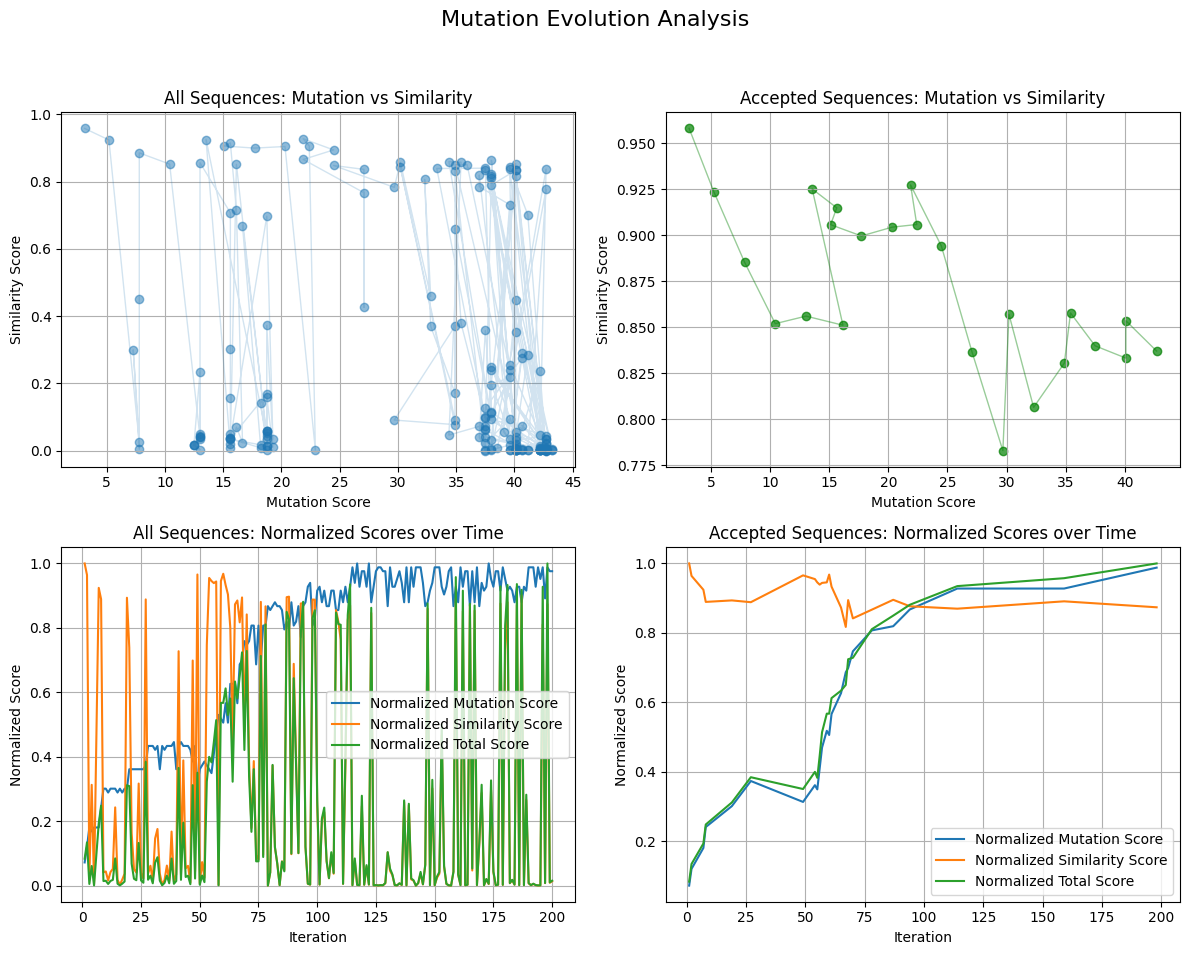

In [18]:
#@title Plot sequence history

import matplotlib.pyplot as plt
import numpy as np

# Assuming the history dictionary is loaded from the previous cell
# history = np.load(history_filename.replace('.pkl', '.npy'), allow_pickle=True).item()

all_iterations = history['all_iterations']
all_mutation_scores = history['all_mutation_scores']
all_sim_scores = history['all_sim_scores']
all_total_scores = history['all_total_scores']

accepted_iterations = history['accepted_iterations']
accepted_mutation_scores = history['accepted_mutation_scores']
accepted_sim_scores = history['accepted_sim_scores']
accepted_total_scores = history['accepted_total_scores']

# Normalize scores for the time series plots
# Find the max values across both all and accepted scores to normalize consistently
max_mutation_score = max(max(all_mutation_scores) if all_mutation_scores else 0,
                         max(accepted_mutation_scores) if accepted_mutation_scores else 0)
max_sim_score = max(max(all_sim_scores) if all_sim_scores else 0,
                    max(accepted_sim_scores) if accepted_sim_scores else 0)
max_total_score = max(max(all_total_scores) if all_total_scores else 0,
                      max(accepted_total_scores) if accepted_total_scores else 0)


normalized_all_mutation_scores = [score / max_mutation_score if max_mutation_score > 0 else 0 for score in all_mutation_scores]
normalized_all_sim_scores = [score / max_sim_score if max_sim_score > 0 else 0 for score in all_sim_scores]
normalized_all_total_scores = [score / max_total_score if max_total_score > 0 else 0 for score in all_total_scores]

normalized_accepted_mutation_scores = [score / max_mutation_score if max_mutation_score > 0 else 0 for score in accepted_mutation_scores]
normalized_accepted_sim_scores = [score / max_sim_score if max_sim_score > 0 else 0 for score in accepted_sim_scores]
normalized_accepted_total_scores = [score / max_total_score if max_total_score > 0 else 0 for score in accepted_total_scores]


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Mutation Evolution Analysis', fontsize=16)

# Subplot 1: All sequences - Mutation vs Similarity Scatter
axes[0, 0].scatter(all_mutation_scores, all_sim_scores, alpha=0.5, label='All Mutations')
axes[0, 0].plot(all_mutation_scores, all_sim_scores, alpha=0.2, linestyle='-', linewidth=1)
axes[0, 0].set_xlabel('Mutation Score')
axes[0, 0].set_ylabel('Similarity Score')
axes[0, 0].set_title('All Sequences: Mutation vs Similarity')
axes[0, 0].grid(True)

# Subplot 2: Accepted sequences - Mutation vs Similarity Scatter
axes[0, 1].scatter(accepted_mutation_scores, accepted_sim_scores, color='green', alpha=0.7, label='Accepted Mutations')
axes[0, 1].plot(accepted_mutation_scores, accepted_sim_scores, color='green', alpha=0.4, linestyle='-', linewidth=1)
axes[0, 1].set_xlabel('Mutation Score')
axes[0, 1].set_ylabel('Similarity Score')
axes[0, 1].set_title('Accepted Sequences: Mutation vs Similarity')
axes[0, 1].grid(True)

# Subplot 3: All sequences - Scores over Time (Normalized)
axes[1, 0].plot(all_iterations, normalized_all_mutation_scores, label='Normalized Mutation Score')
axes[1, 0].plot(all_iterations, normalized_all_sim_scores, label='Normalized Similarity Score')
axes[1, 0].plot(all_iterations, normalized_all_total_scores, label='Normalized Total Score')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Normalized Score')
axes[1, 0].set_title('All Sequences: Normalized Scores over Time')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Subplot 4: Accepted sequences - Scores over Time (Normalized)
axes[1, 1].plot(accepted_iterations, normalized_accepted_mutation_scores, label='Normalized Mutation Score')
axes[1, 1].plot(accepted_iterations, normalized_accepted_sim_scores, label='Normalized Similarity Score')
axes[1, 1].plot(accepted_iterations, normalized_accepted_total_scores, label='Normalized Total Score')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Normalized Score')
axes[1, 1].set_title('Accepted Sequences: Normalized Scores over Time')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

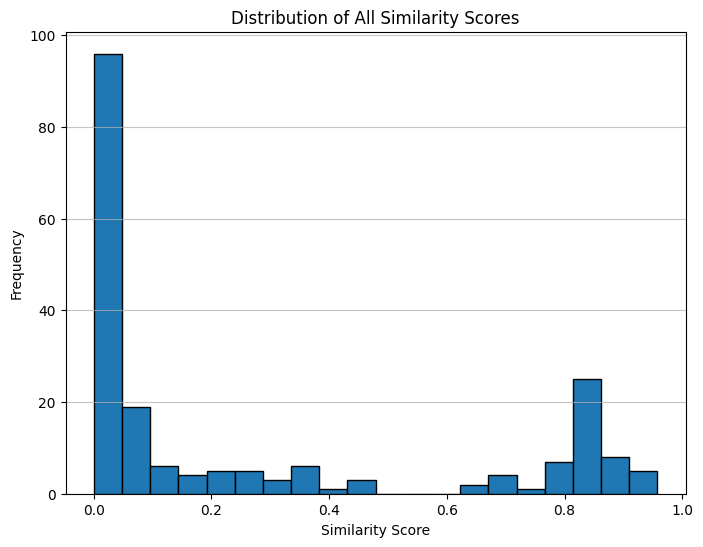

In [19]:
import matplotlib.pyplot as plt

# Assuming 'all_sim_scores' is available from the previous cell's execution
# If not, you might need to load the history again:
# history = np.load(history_filename.replace('.pkl', '.npy'), allow_pickle=True).item()
# all_sim_scores = history['all_sim_scores']

plt.figure(figsize=(8, 6))
plt.hist(all_sim_scores, bins=20, edgecolor='black')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of All Similarity Scores')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Task
Generate visualizations showing the position-dependent amino acid distributions for the top 20 scoring sequences and all accepted sequences from the `history` dictionary.

## Identify top sequences

### Subtask:
Identify the DNA sequences corresponding to the top 20 total scores from the `history` dictionary.


**Reasoning**:
Access the history data, sort the total scores, and retrieve the top 20 protein sequences to prepare for finding their corresponding DNA sequences.



In [20]:
# Access data from history
all_total_scores = history['all_total_scores']
all_tried_protein_sequences = history['all_tried_protein_sequences']
all_iterations = history['all_iterations'] # Keep track of iterations to help potentially link back

# Get indices of all scores sorted in descending order
sorted_indices = np.argsort(all_total_scores)[::-1]

# Select the top 20 indices
top_20_indices = sorted_indices[:20]

# Retrieve the top 20 protein sequences
top_20_protein_sequences = [all_tried_protein_sequences[i] for i in top_20_indices]

print("Top 20 Protein Sequences:")
for i, seq in enumerate(top_20_protein_sequences):
    print(f"{i+1}: {seq} (Score: {all_total_scores[top_20_indices[i]]:.3f})")

# Since the DNA sequences were not explicitly stored for every tried protein sequence in the history,
# and reconstructing them based solely on the protein sequence and original_seq is not straightforward
# due to silent mutations and the iterative nature, we cannot definitively link the top 20 protein
# sequences back to their exact DNA sequences from the current history structure.
# To achieve the next step of the main task (position-dependent amino acid distributions),
# we need the protein sequences themselves, which we have.
# For the subtask of finding the *DNA* sequences, we cannot complete it with the current history data structure.
# We will proceed with the protein sequences for the main task and report failure for the subtask as defined.

Top 20 Protein Sequences:
1: LKVLFLQHGEVHNIADSYANRYLFKKSIAVKA (Score: 35.746)
2: LKVLFLQHGEVHNIADSYANQYLYKKSIAIKA (Score: 34.227)
3: LKVLFLQHGEIHNIADSYANRYLYKKSIAVKA (Score: 33.456)
4: MKVLFLQHGEVHNIADSYANRYLYKKSIAVKA (Score: 33.413)
5: LKVLFLQHGEVHNIADTYANRYLYKKSIAVKA (Score: 33.354)
6: LKVLFLQHGEVHNIADSYANRYVYKKSIAVKA (Score: 33.197)
7: LKVLFLQHGEVHNIADQYANRYLYKKSIAVKA (Score: 33.162)
8: LKVLFLQHGEVHNLADSYANRYLYKKSIAVKA (Score: 32.820)
9: LKVLFLQHGEVHNIADSFANRYLYKKSIAVKA (Score: 32.726)
10: MKVLFLKHGEVHNIADSYANQYLFKKSIAVKA (Score: 31.493)
11: LKVIFLQHGEVHNIADSYANQYLYKKSIAVKA (Score: 31.301)
12: LKVLFLQHGEVHNIAESYANRYLYKKSIAVKA (Score: 31.271)
13: LKVLFLQHGEVHNIADSYANRYLYNKSIAVKA (Score: 31.083)
14: LKVLFLQHGEVHNIADSYANQYLYRKSIAVKA (Score: 30.826)
15: MKVLFLQHGEVHNIADSYANQYLYKKSIAIKA (Score: 30.553)
16: MKVLFLKRGEVHNIADSYANSYLYKKSIAVKA (Score: 30.376)
17: MKVLFLQHGEVHNIADSYANQYMYKKSIAVKA (Score: 30.298)
18: MKVLFLQHGEVHNIADSYANQYLYHKSIAVKA (Score: 30.031)
19: MKVLFLQHGRVHNIADSYANQYLYK